In [1]:
import os

os.chdir('/biodata/franco/zsuzsa_lab/jupyter')
from Bio import SeqIO
from embeddings_config import embedding_data, avail_models
import numpy as np
import os
import argparse
import torch
from tqdm import tqdm
print(avail_models)

import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'mono', fontsize = 14, dpi=100)

['halft5', 'prott5', 'esmb1']


In [2]:
!pwd

/biodata/franco/zsuzsa_lab/jupyter


In [3]:
model = "halft5"
sel_embedding = 'halft5'

if sel_embedding not in avail_models:
    print("ERROR: Selected model not available")
    raise

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
if sel_embedding == "halft5":
    embedder = embedding_data[model]["embedder"](model_directory=embedding_data[sel_embedding]['dir'], half_model=True, device=device)
else:
    embedder = embedding_data[model]["embedder"](model_directory=embedding_data[sel_embedding]['dir'], device=device)


cuda


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [4]:
# Generate sequences of varying length of a single-letter aminoacid
# Then obtain embedding for those sequences

# generate sequences
seqs = []
embeddings = []
for i in tqdm(range(1, 201)):
    seq = "A" * i
    seqs.append(seq)
    # get embedding
    embeddings.append(embedder.embed(seq))



100%|██████████| 200/200 [00:05<00:00, 34.77it/s]


In [6]:
import umap
import pandas as pd
import plotly.express as px

# for each element of the sequence, get the sequence length and distance to the edge
seq_lengths = []
aa_dists = []
for i in range(len(seqs)):
    l = len(seqs[i])
    seq_lengths += [l for j in range(l)]
    for i in range(l):    
        halfway_point = l/2
        if i < halfway_point:
            dist = i
        else:
            dist = l - i
        aa_dists += [dist]

# make UMAP of embeddings
dummy_embedding_matrix = np.vstack(embeddings)
print(dummy_embedding_matrix.shape)
my_umap = umap.UMAP(n_neighbors=200, min_dist=.25) # metric='cosine'
dummy_umap_embedding = my_umap.fit_transform(dummy_embedding_matrix)


(20100, 1024)


In [ ]:

# plot UMAP embedding
df = pd.DataFrame(dummy_umap_embedding, columns=['x', 'y'])
df['length'] = seq_lengths
df['dist'] = aa_dists
f = px.scatter(df, x='x', y='y', color='length', size='dist', width=900, height=800)
f.update_traces(marker=dict(opacity=0.5, line=dict(color='DarkSlateGrey', width=0.5)))

f.write_image(f"plots/umap_polyA_size_dist2N_color_length_T5.png", engine='kaleido')

f.show()

In [7]:
from scipy.spatial.distance import cosine

# organize sequence embeddings by length
seqs_by_length = {}
acum = 0
for i in range(len(seqs)):
    l = len(seqs[i])
    seqs_by_length[l] = dummy_embedding_matrix[acum:acum+l]
    acum = l

refseq_emb = seqs_by_length[200]
dummy_cos_pairs = {}
for l in tqdm(seqs_by_length.keys()):
    # print(s, seqs_by_length[s].shape)
    # Calculate cosine distance
    if l == 200:
        continue
    emb = seqs_by_length[l]
    dummy_cos_distances = np.zeros((emb.shape[0], refseq_emb.shape[0]))
    for j in range(refseq_emb.shape[0]):
        for i in range(emb.shape[0]):
            dist = cosine(emb[i,:], refseq_emb[j,:])
            dummy_cos_distances[i,j] = dist
    dummy_cos_pairs[emb.shape[0]] = dummy_cos_distances

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


In [8]:
from scipy.spatial.distance import euclidean

# organize sequence embeddings by length
seqs_by_length = {}
acum = 0
for i in range(len(seqs)):
    l = len(seqs[i])
    seqs_by_length[l] = dummy_embedding_matrix[acum:acum+l]
    acum = l

# calculate euclidean distances
from scipy.spatial.distance import euclidean

refseq_emb = seqs_by_length[200]
dummy_euc_pairs = {}
for l in tqdm(seqs_by_length.keys()):
    # print(s, seqs_by_length[s].shape)
    # Calculate euclidean distance
    if l == 200:
        continue
    emb = seqs_by_length[l]
    dummy_euc_distances = np.zeros((emb.shape[0], refseq_emb.shape[0]))
    for j in range(refseq_emb.shape[0]):
        for i in range(emb.shape[0]):
            dist = euclidean(emb[i,:], refseq_emb[j,:])
            dummy_euc_distances[i,j] = dist
    dummy_euc_pairs[emb.shape[0]] = dummy_euc_distances

100%|██████████| 200/200 [00:33<00:00,  6.05it/s]


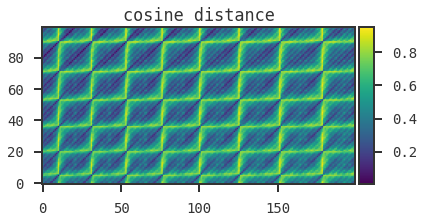

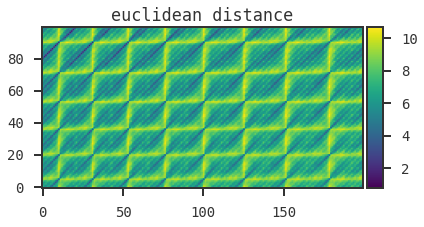

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
mpl_stylesheet.banskt_presentation(fontfamily = 'mono', fontsize = 14, dpi=100)

fig = plt.figure()
ax  = fig.add_subplot(111)
c = ax.imshow(dummy_cos_pairs[100], origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(c, cax=cax)
ax.set_title("cosine distance")
plt.tight_layout()
plt.show()


fig = plt.figure()
ax  = fig.add_subplot(111)
d = ax.imshow(dummy_euc_pairs[100], origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(d, cax=cax)
ax.set_title("euclidean distance")
plt.savefig("plots/euc_distance_polyA_size100v200_T5.png", bbox_inches='tight')
plt.tight_layout()
plt.show()


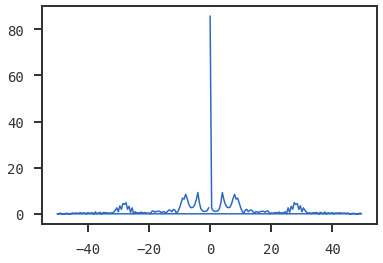

In [10]:
# find Fourier transform of the distance matrix
from scipy.fft import fft, fftfreq

# calculate the Fourier spectrum of the cosine distance matrix
yf = fft(dummy_cos_pairs[100][0,:])
xf = fftfreq(yf.size, d=1/100)

plt.plot(xf, np.abs(yf))
plt.show()

# plot the distance for one row of the euclidean distance matrix, we can see the periodicity
f = px.line(dummy_euc_pairs[100][0,:], width=1200, height=400, title="Euclidean distance for one row of the distance matrix - T5")
f.write_image("plots/euc_distance_row_polyA_size100_T5.png", engine='kaleido')
f.show()

In [11]:
# average over 1024-d of each aminoacid in the polyA sequence. Periodicity increments by 1 between peaks
# similar to above, but no distance here, just mean of the 1024-d embedding
avg_aa = np.mean(seqs_by_length[100], axis=1)
px.line(avg_aa)

In [12]:
# now show distance between prot-level embeddings

prot_level_embs = {}
for l in seqs_by_length.keys():
    emb = seqs_by_length[l]
    prot_level_embs[l] = np.mean(emb, axis=0)

refseq_prot_emb = prot_level_embs[200]
protlevel_distmat = np.zeros((201,201))
for i in tqdm(range(1,201)):
    for j in range(i,201):
        dist = euclidean(prot_level_embs[i], prot_level_embs[j])
        protlevel_distmat[i,j] = dist
    

100%|██████████| 200/200 [00:00<00:00, 1254.70it/s]


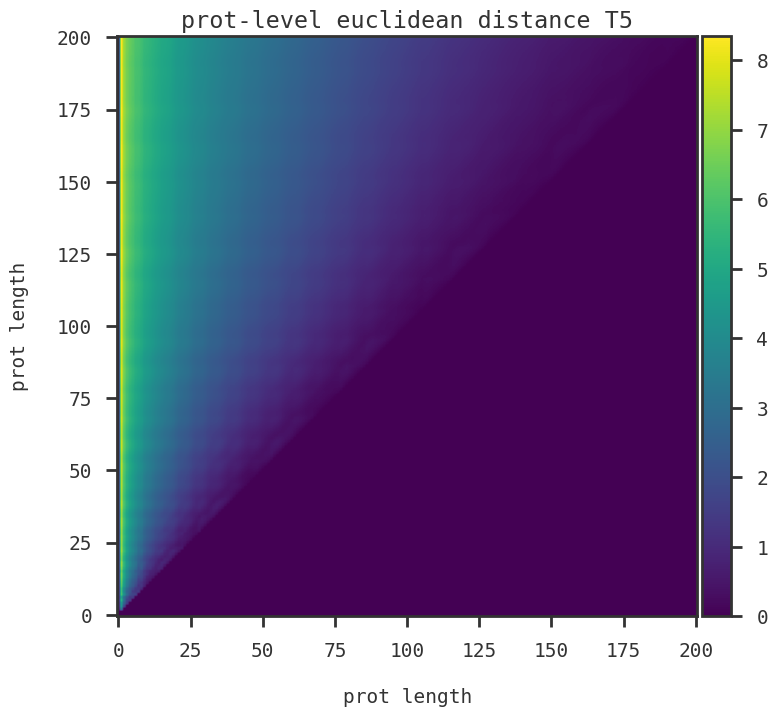

In [14]:
# c = plt.imshow(protlevel_distmat.T, origin='lower')
# plt.colorbar(c)
mpl_stylesheet.banskt_presentation(fontfamily = 'mono', fontsize = 14, dpi=100)

fig = plt.figure()
ax  = fig.add_subplot(111)
d = ax.imshow(protlevel_distmat.T, origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(d, cax=cax)
ax.set_title("prot-level euclidean distance T5")
ax.set_ylabel("prot length")
ax.set_xlabel("prot length")
plt.savefig("plots/euc_distance_protlevel_polyA_T5.png", bbox_inches='tight')
plt.tight_layout()
plt.show()


In [ ]:
### Let's find the distance between all aminoacids in a natural protein

import collections
disprot_dict = collections.defaultdict(dict)

with open("/biodata/franco/datasets/disprot/disprot_OK_fullset_2023_12.fasta") as instrm:
    for record in SeqIO.parse(instrm, "fasta"):
            disprot_dict[record.id]['seq'] = str(record.seq)
with open("/biodata/franco/datasets/disprot/disprot_OK_fullset_annotations_2023_12.fasta") as instrm:
    for record in SeqIO.parse(instrm, "fasta"):
            disprot_dict[record.id]['disorder'] = str(record.seq)

P49913 170
found 11 S


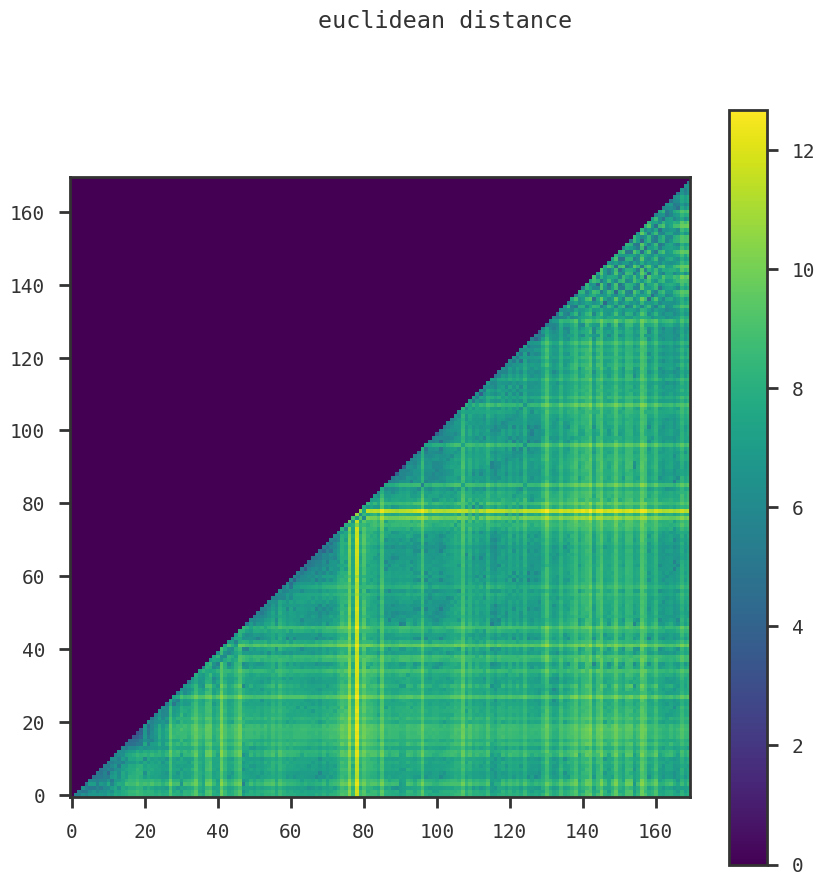

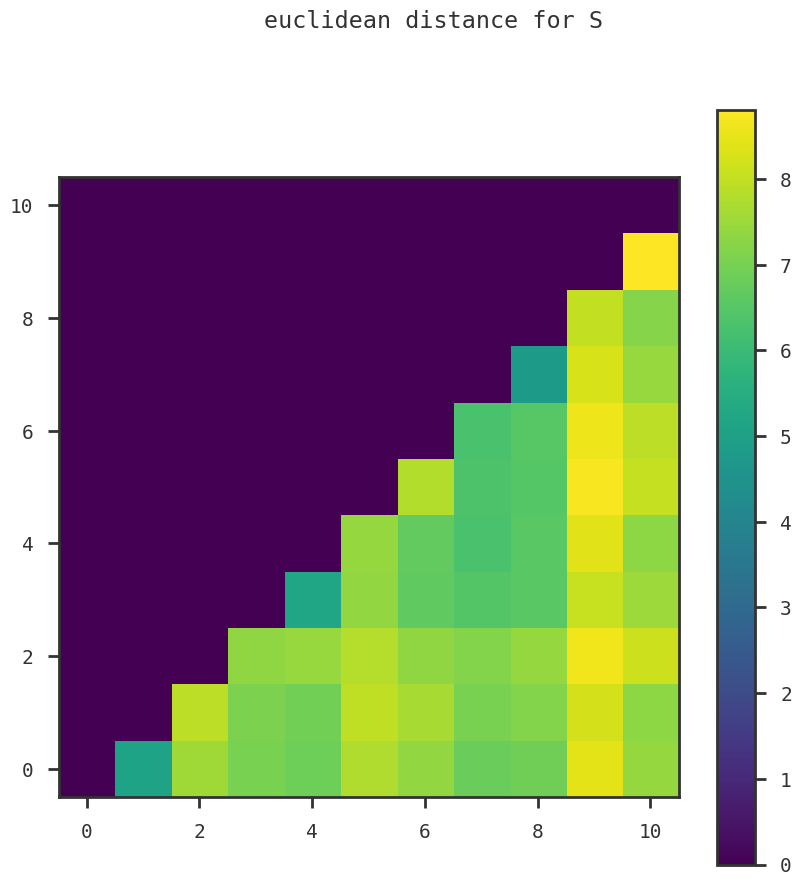

In [ ]:
## Calculate distance between aa-level embeddings
# There seems to be no similar periodicity as in the polyA sequence

for k in disprot_dict.keys():
    if len(disprot_dict[k]['seq']) < 200:
        # embed
        print(k, len(disprot_dict[k]['seq']))
        seq_emb = embedder.embed(disprot_dict[k]['seq'])

        aa_target = "S"
        aa_target_ix = [i for i in range(len(disprot_dict[k]['seq'])) if disprot_dict[k]['seq'][i] == aa_target]
        print("found %d %s" % (len(aa_target_ix), aa_target))

        # calculate euclidean distance between all pairs of aminoacids
        euclidean_dist = np.zeros((seq_emb.shape[0], seq_emb.shape[0]))
        for i in range(seq_emb.shape[0]):
            for j in range(i, seq_emb.shape[0]):
                dist = euclidean(seq_emb[i,:], seq_emb[j,:])
                euclidean_dist[i,j] = dist
        

        plt.figure(figsize=(10,10))
        d = plt.imshow(euclidean_dist, origin='lower')
        plt.colorbar(d)
        plt.suptitle("euclidean distance")
        plt.show()

        plt.figure(figsize=(10,10))
        d = plt.imshow(euclidean_dist[aa_target_ix,:][:,aa_target_ix], origin='lower')
        plt.colorbar(d)
        plt.suptitle("euclidean distance for %s" % aa_target)
        plt.show()
        break

    